In [29]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/bigdataleeky/python/main/data/mobile_phone.csv')
df.head()

,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59


In [30]:
from datetime import datetime
import time
def change_unixtime(str_date):
    timestamp =  time.mktime(datetime.strptime(str_date,'%Y-%m-%d').timetuple() )
    return timestamp

In [31]:
df['create_date'][0][:10]

'2017-03-19'

In [32]:
change_unixtime(df['create_date'][0][:10])

1489881600.0

In [33]:
df['create_date_unixtime'] = df['create_date'].apply(lambda x :change_unixtime(x[:10]) )
df['create_date_unixtime'][:6]

0    1.489882e+09
1    1.477440e+09
2    1.477354e+09
3    1.490227e+09
4    1.460333e+09
5    1.490141e+09
Name: create_date_unixtime, dtype: float64

In [34]:
# min-max scaling  - std
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min
# sklearn.preprocessing.MinMaxScaler

# (각 요소 - 평균) / (최대값 - 최소값)
df['create_unixtime_scale'] = (df['create_date_unixtime'] - df['create_date_unixtime'].min()) / \
        (df['create_date_unixtime'].max() - df['create_date_unixtime'].min())
df[['create_date','create_date_unixtime','create_unixtime_scale']].head()  

,create_date,create_date_unixtime,create_unixtime_scale
0,2017-03-19 4 35 00 PM,1.489882e+09,0.985612
1,2016-10-26 12 08 00 PM,1.477440e+09,0.640288
2,2016-10-25 12 52 00 PM,1.477354e+09,0.637890
3,2017-03-23 11 14 00 PM,1.490227e+09,0.995204
4,2016-04-11 7 35 00 PM,1.460333e+09,0.165468


In [35]:
# phone model 을 분리
df['phone_model_st'] =  df['phone_model'].apply(lambda x : x.split(" ")[-1])
df['phone_model_detail'] = df['phone_model'].apply(lambda x : ' '.join( x.split(" ")[:-1]))
df[['phone_model_st','phone_model_detail']].head()

,phone_model_st,phone_model_detail
0,64gb,iphone 6
1,32gb,galaxy s6 edge
2,32gb,galaxy s6
3,32gb,lg g5
4,32gb,lg u


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


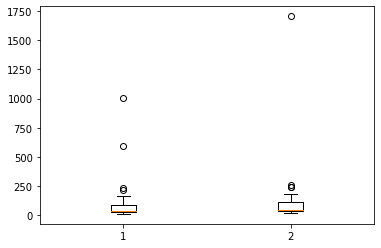

In [36]:
# 모델별 거래
model_counts =  df['phone_model'].value_counts()
model_detail_counts =  df['phone_model_detail'].value_counts()

temp = [model_counts, model_detail_counts]
# 두 피처간의 기종별 거래 데이터
import matplotlib.pyplot as plt

plt.boxplot(temp)
plt.show()

In [37]:
# 기종명+용량으로 
model_storage_factory_dic = {}

for index, row in  df.iterrows():
    model_concat =  (row['phone_model_detail'], row['phone_model_st'])
    if model_concat in model_storage_factory_dic:
        pass
    else:
        model_storage_factory_dic[model_concat] = row['factory_price']
str(model_storage_factory_dic)[:50]

"{('iphone 6', '64gb'): 924000, ('galaxy s6 edge', "

In [38]:
# z-score.....  평균으로부터 표준편차의 몇배 만큼 떨어져 있는지를 보여주는 지수
# z = (x - mean) / std
# price z score : 어떤 데이터의 가격이 해당 기종의 평균에 비해 어느정도 높거나 낮은지 알 수 있게
df['zscore_price'] = df.groupby('phone_model_detail')['price'].transform(lambda x: (x - x.mean()) / x.std())

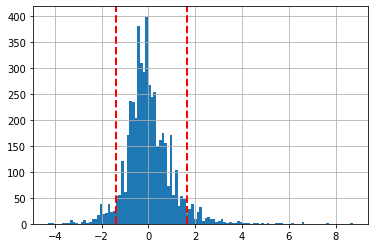

In [39]:
ax = df['zscore_price'].hist(bins='auto')
lower= df['zscore_price'].quantile(0.05)
upper = df['zscore_price'].quantile(0.95)

ax.axvline(x = lower,color = 'r', linestyle='dashed', linewidth=2)
ax.axvline(x = upper,color = 'r', linestyle='dashed', linewidth=2)

plt.show()


In [40]:
def makepricelevel(price, lower, upper):
    if price > upper:
        return 2
    elif price > lower:
        return 1
    else:
        return 0;

In [41]:
df['lower_price'] =  df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.05))
df['upper_price'] =  df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.95))
df['price_level'] =  df.apply(lambda x : makepricelevel(x['price'],x['lower_price'],x['upper_price']), axis=1)
df[['price','lower_price','upper_price','price_level','text' ]].head()

,price,lower_price,upper_price,price_level,text
0,550000.0,180000.0,680000.0,1,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...
1,380000.0,180000.0,414000.0,1,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...
2,300000.0,150000.0,349000.0,1,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...
3,290000.0,100000.0,500000.0,1,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...
4,280000.0,18000.0,400000.0,1,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...


In [42]:
import pickle
import re
with open('stopwords.pkl', 'rb') as f:
  swords =  pickle.load(f)    

In [43]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 448 kB 67.1 MB/s 


In [44]:
from konlpy.tag import Okt
# ‘+’를 제외한 특수문자를 제거하고, 숫자형태의 문자를 제거합니다.
def text_cleaning(text):
    text = ''.join(c for c in text if c.isalnum() or c in '+, ') # isalnum or 해당 문자를 포함하는지
    text = ''.join([i for i in text if not i.isdigit()])
    return text
    
def get_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] not in swords]

In [45]:
# 위 함수들을 적용한 형태소 추출을 테스트합니다.
df['text'] = df['text'].apply(lambda x: text_cleaning(x))
result = get_pos(df['text'][0])
print(result)

['+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '징', '애플', '라이트', '홈', '버튼', '링', '카메라', '링', '볼륨', '버튼', '슬립', '버튼', '검금', '심플', '튀지', '않게', '이쁘게', '했구요', '유심', '꽂고', '바로', '사용', '하시면', '됩니다', '사람', '이냐', '자주', '물어보고', '실제', '더욱', '이쁩니다', '밤', '영롱하게', '맥북', '뒷', '사과', '로고', '비춰지고', '요전', '넘어가기', '위해', '합니다', '가능합니다', '박스', '어머니', '버리시고', '이어폰', '충전기', '정품', '드립니다', '직거래', '우선', '순', '위로', '정', '싶으시면', '선', '입금', '택배', '발송', '해드리겠습니다', '믿으시면', '직거래', '하시길', '추천', '해요', '안전', '합니다', '서울시', '강남구', '역삼동', '차병원', '사거리', '근처', '가격']


In [46]:
from collections import Counter

# get_pos 함수를 모든 텍스트 데이터에 적용하여 형태소 말뭉치를 추출합니다.
corpus = sum(df['text'].apply(lambda x: get_pos(x)).tolist(), [])
corpus

# token : 단어 개념
# corpus(말뭉치) : token과 유사한 개념

['+',
 '애플',
 '라이트',
 '팝니다',
 '+',
 '애플',
 '라이트',
 '팝니다',
 '+',
 '애플',
 '라이트',
 '팝니다',
 '리퍼',
 '기간',
 '만료',
 '되어서',
 '징',
 '하게',
 '되었습니다',
 '상태',
 '초',
 'a',
 '급',
 '스',
 '없습니다',
 '+',
 '애플',
 '라이트',
 '팝니다',
 '+',
 '애플',
 '라이트',
 '팝니다',
 '리퍼',
 '기간',
 '만료',
 '되어서',
 '징',
 '하게',
 '되었습니다',
 '상태',
 '초',
 'a',
 '급',
 '스',
 '없습니다',
 '징',
 '애플',
 '라이트',
 '홈',
 '버튼',
 '링',
 '카메라',
 '링',
 '볼륨',
 '버튼',
 '슬립',
 '버튼',
 '검금',
 '심플',
 '튀지',
 '않게',
 '이쁘게',
 '했구요',
 '유심',
 '꽂고',
 '바로',
 '사용',
 '하시면',
 '됩니다',
 '사람',
 '이냐',
 '자주',
 '물어보고',
 '실제',
 '더욱',
 '이쁩니다',
 '밤',
 '영롱하게',
 '맥북',
 '뒷',
 '사과',
 '로고',
 '비춰지고',
 '요전',
 '넘어가기',
 '위해',
 '합니다',
 '가능합니다',
 '박스',
 '어머니',
 '버리시고',
 '이어폰',
 '충전기',
 '정품',
 '드립니다',
 '직거래',
 '우선',
 '순',
 '위로',
 '정',
 '싶으시면',
 '선',
 '입금',
 '택배',
 '발송',
 '해드리겠습니다',
 '믿으시면',
 '직거래',
 '하시길',
 '추천',
 '해요',
 '안전',
 '합니다',
 '서울시',
 '강남구',
 '역삼동',
 '차병원',
 '사거리',
 '근처',
 '가격',
 's',
 '팝니다',
 '직거래',
 's',
 '품명',
 's',
 '제품',
 '상태',
 '사진',
 '참고',
 '용량',
 '선택',
 '약정',
 '여부',
 '가능',
 '요금',

In [47]:
# 추출된 형태소 말뭉치에서 가장 많이 등장한 형태소 2500개를 추출합니다. --> Counter()

# 텍스트 중 의미 없는 기호나 문자는 모두 제거하고
# counter.most_common : 가장 많이 등장한 형태소 중 2500개만 추출 ( --> 하이퍼 파라미터 )

counter = Counter(corpus)
common_words = [key for key, _ in counter.most_common(2500)]
common_words[:10]

['입니다', '직거래', 's', '합니다', '택배', '사용', '급', '상태', '팝니다', '가능합니다']

In [48]:
df['price_level'].value_counts()

1    4388
0     334
2     229
Name: price_level, dtype: int64

In [49]:
df[df['price_level'] == 0]

,create_date,price,text,phone_model,factory_price,maker,price_index,create_date_unixtime,create_unixtime_scale,phone_model_st,phone_model_detail,zscore_price,lower_price,upper_price,price_level
9,2016-03-23 9 58 00 AM,15000.0,"팝니다 미국 유심 심플모바일 tmobile망 마이크로 유심 개 개당 만,무료...",galaxy note 2 32gb,1089000,samsung,94.90,1.458691e+09,0.119904,32gb,galaxy note 2,-0.710651,28500.0,330000.0,0
10,2016-03-22 10 41 00 AM,15000.0,"팝니다 미국 유심 심플모바일 tmobile망 마이크로 유심 개 개당 만,무료...",galaxy note 2 32gb,1089000,samsung,94.90,1.458605e+09,0.117506,32gb,galaxy note 2,-0.710651,28500.0,330000.0,0
11,2016-10-11 11 23 00 PM,15000.0,lgu+ 피쳐폰 폴더 슬라이드 g폰 g폰 정리합니다 피쳐폰 lgu+ 피쳐폰 폴더 슬...,wine smart jazz 4gb,242000,lg,103.05,1.476144e+09,0.604317,4gb,wine smart jazz,-0.732123,20000.0,150000.0,0
12,2016-10-11 9 19 00 PM,15000.0,skt g폰 정리합니다 폴더 슬라이드 x 용 휴대폰 sktg폰 정리합니다 폴더...,wine smart jazz 4gb,242000,lg,103.05,1.476144e+09,0.604317,4gb,wine smart jazz,-0.732123,20000.0,150000.0,0
13,2016-10-26 2 03 00 PM,15000.0,skt kt g 유심방식 피쳐폰 정리합니다 폴더폰 슬라이드폰 skt kt g 유심...,lg u 32gb,396000,lg,103.05,1.477440e+09,0.640288,32gb,lg u,-0.753369,18000.0,400000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3551,2016-10-23 2 02 00 PM,432000.0,아이폰 제트블랙 g 새제품 팔아요 ...,iphone 7 128gb,999000,apple,103.05,1.477181e+09,0.633094,128gb,iphone 7,-1.726227,597000.0,1200000.0,0
3552,2016-10-21 1 40 00 PM,432000.0,아이폰플러스 기가 직접거래 ...,iphone 7 plus 128gb,1152800,apple,103.05,1.477008e+09,0.628297,128gb,iphone 7 plus,-1.846772,628200.0,1200000.0,0
4143,2016-10-21 7 09 00 PM,530000.0,"아이폰 g 로즈골드 팝니다a급, 정상해지, 확정기변 가능, 구성품미개봉 풀박 아이...",iphone 7 32gb,869000,apple,103.05,1.477008e+09,0.628297,32gb,iphone 7,-1.281068,597000.0,1200000.0,0
4144,2016-07-13 9 30 00 AM,530000.0,"아이폰 g 로즈골드 팝니다a급, 정상해지, 확정기변가능, 구성품미개봉 풀박 아이폰...",iphone 7 32gb,869000,apple,102.59,1.468368e+09,0.388489,32gb,iphone 7,-1.281068,597000.0,1200000.0,0


## **TG-IDF**
- TF : Term Frequency
  - 어떤 단어가 등장하는 빈도수
  - 두 음절 이상의 글자만 Count

- DF : Document Frequency
  - 특정 단어가 나타나는 문장의 수
  - 

ex. My home is very good
ex. I'm gonna to home
ex. My home is spacious

TF : home - 3개
DF : home(이 포함된 문장) - 3개

- 한 음절의 글씨는 무시
- IDF : df를 역수변환
  - idf = lof((i+n) / (i+df)) +1


- **TF-IDF**
  - TF X IDF
  - 긍정적인 단어와 부정적인 단어를 분류하여 추출
  - 이와 같은 구분을 잘 인식할 수 있도록 만들어 주기 위한 도구 : **CountVectorizer**

In [50]:
from sklearn.model_selection import train_test_split # 학습/검증세트 분류
from sklearn.feature_extraction.text import CountVectorizer # 백터화 하기
from sklearn.feature_extraction.text import TfidfTransformer # 긍정/부정 데이터 분류 (단어 자체를 연산 가능한 수로 표현)

# 빈출 형태소를 제외한 모든 형태소를 제거하는 함수를 정의합니다.
def get_common_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] in common_words]

# 1:3:1 비율로 랜덤 샘플링을 수행합니다. 
negative_random = df[df['price_level']==0].sample(229, random_state=30)
neutral_random = df[df['price_level']==1].sample(229*3, random_state=30) # price의 중간 데이터(1)을 늘려줌
positive_random = df[df['price_level']==2].sample(229, random_state=30)

# 샘플링 완료된 데이터셋을 정의합니다.
df_sample = negative_random.append(neutral_random).append(positive_random)

# TF-IDF를 수행하여 피처를 변환합니다.
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_common_pos(x)) # 2500개의 문자에만 사용하기 위한 처리
X = index_vectorizer.fit_transform(df_sample['text'].tolist()) # CountVectorizer한 데이터 중 텍스트 데이터만 추출
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

# 감성 분류를 위한 학습 데이터셋을 정의합니다.
y = df_sample['price_level']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30)
print(x_train.shape)
print(x_test.shape)

(916, 2437)
(229, 2437)


**SVC**


서포트 벡터 머신(이하 SVM)은 결정 경계(Decision Boundary), 즉 분류를 위한 기준 선을 정의하는 모델이다. 그래서 분류되지 않은 새로운 점이 나타나면 경계의 어느 쪽에 속하는지 확인해서 분류 과제를 수행할 수 있게 된다.

결국 이 결정 경계라는 걸 어떻게 정의하고 계산하는지 이해하는 게 중요하다는 뜻이다.

https://hleecaster.com/ml-svm-concept/

In [51]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC # Support Vector Machine : 비선형 데이터를 다룸

# 비선형 SVM 분류 모델을 학습하고 평가합니다.
svm = SVC(kernel='rbf', C=10.0, random_state=0, gamma=0.10)
svm.fit(x_train, y_train)
y_pred_ksvc = svm.predict(x_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred_ksvc))

Accuracy: 0.74


In [52]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_ksvc)
print(confmat)

[[ 19  19   2]
 [  8 124  13]
 [  1  17  26]]


# RandomForest를 이용한 재학습
감성 분류를 위한 텍스트를 긍정과 부정의 형태로 분류한 데이터를 사용하여 재학습 하기

In [53]:
# Ctrl_Spacebar : 자동완성 키
X = index_vectorizer.transform(df['text'].tolist())
X = tfidf_vectorizer.fit_transform(X)

In [54]:
df['product_status'] = pd.Series(svm.predict(X)) 

# CountVectorizer 값을 가지고 TfidfTransformer로 감성 분류
# 위와 같이 준비된 데이터를 가지고 비선형 SVM 분류 모델을 학습하고 평가
# 평가된 모델의 예측값을 사용하기 위해 데이터셋에 예측값 추가해 준 것이 --> df['product_status']
# 라벨이 0, 1, 2 로, 3개 이상이므로 원핫인코딩을 해 줌

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   create_date            4951 non-null   object 
 1   price                  4951 non-null   float64
 2   text                   4951 non-null   object 
 3   phone_model            4951 non-null   object 
 4   factory_price          4951 non-null   int64  
 5   maker                  4951 non-null   object 
 6   price_index            4951 non-null   float64
 7   create_date_unixtime   4951 non-null   float64
 8   create_unixtime_scale  4951 non-null   float64
 9   phone_model_st         4951 non-null   object 
 10  phone_model_detail     4951 non-null   object 
 11  zscore_price           4951 non-null   float64
 12  lower_price            4951 non-null   float64
 13  upper_price            4951 non-null   float64
 14  price_level            4951 non-null   int64  
 15  prod

In [56]:
df.head(1)

,create_date,price,text,phone_model,factory_price,maker,price_index,create_date_unixtime,create_unixtime_scale,phone_model_st,phone_model_detail,zscore_price,lower_price,upper_price,price_level,product_status
0,2017-03-19 4 35 00 PM,550000.0,아이폰플러스 블랙+애플라이트 기가 팝니다 아이폰플러스 블랙+애플라이트 기가 팝니다...,iphone 6 64gb,924000,apple,95.96,1.489882e+09,0.985612,64gb,iphone 6,0.910563,180000.0,680000.0,1,1


### **학습에 필요한 데이터들 취합하기**

In [57]:
df = df[['price', 'factory_price', 'maker', 'price_index', 'create_date_unixtime', 'phone_model_st', 'phone_model_detail', 'product_status']]

더이상 텍스트 정보는 필요없음 --> TF_IDF를 이용한 감성 분류법을 통해 사전에 텍스트를 정수화 해 주었기 때문임

In [58]:
df['product_status'].value_counts()

1    3893
2     593
0     465
Name: product_status, dtype: int64

In [59]:
# 원핫인코딩
df = pd.get_dummies(df, columns=['maker', 'phone_model_st', 'phone_model_detail', 'product_status'])

In [60]:
df.head()

,price,factory_price,price_index,create_date_unixtime,maker_apple,maker_huawei,maker_lg,maker_pantech,maker_samsung,maker_sky,...,phone_model_detail_nexus 5x,phone_model_detail_optimus g,phone_model_detail_vega iron2,phone_model_detail_vega secret up,phone_model_detail_wine smart jazz,phone_model_detail_xperia z3,phone_model_detail_y6,product_status_0,product_status_1,product_status_2
0,550000.0,924000,95.96,1.489882e+09,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,380000.0,979000,103.05,1.477440e+09,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,300000.0,854000,103.05,1.477354e+09,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,290000.0,836000,95.96,1.490227e+09,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,280000.0,396000,102.59,1.460333e+09,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### 학습/검증세트 분류

In [61]:
Y = df['price']
X = df.iloc[:,1:]
X.head()

,factory_price,price_index,create_date_unixtime,maker_apple,maker_huawei,maker_lg,maker_pantech,maker_samsung,maker_sky,maker_sony,...,phone_model_detail_nexus 5x,phone_model_detail_optimus g,phone_model_detail_vega iron2,phone_model_detail_vega secret up,phone_model_detail_wine smart jazz,phone_model_detail_xperia z3,phone_model_detail_y6,product_status_0,product_status_1,product_status_2
0,924000,95.96,1.489882e+09,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,979000,103.05,1.477440e+09,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,854000,103.05,1.477354e+09,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,836000,95.96,1.490227e+09,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,396000,102.59,1.460333e+09,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [62]:
x_train, x_target, y_train, y_target = train_test_split(X, Y, test_size=0.2, random_state=42)

In [63]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=1000, random_state=42)
rfr.fit(x_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [64]:
y_train_predict = rfr.predict(x_train)
y_target_predict = rfr.predict(x_target)

In [65]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [66]:
mean_squared_error(y_train, y_train_predict), mean_squared_error(y_target, y_target_predict) # (정답, 예측값)

(4774161470.856794, 9251274293.388544)

In [67]:
r2_score(y_train, y_train_predict), r2_score(y_target, y_target_predict)  # (정답, 예측값)

(0.8983397609393969, 0.8050845257429582)

**피쳐의 중요도 확인**

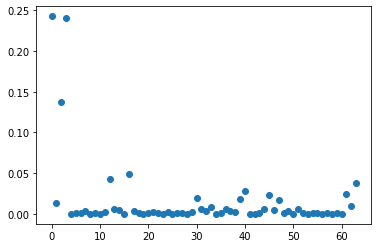

In [68]:
feature_values = rfr.feature_importances_
feature_values
plt.plot(feature_values, 'o')
plt.show()

**x_train, x_target, y_train, y_target**

(훈련데이터, 검증데이터, 훈련데이터의 정답, 검증데이터의 정답)

In [69]:
sorted(list(zip(X.columns, feature_values)), key=lambda x : x[1], reverse=True)[:10]

[('factory_price', 0.2426495164410393),
 ('maker_apple', 0.24040777690237838),
 ('create_date_unixtime', 0.13677209718284963),
 ('phone_model_st_64gb', 0.04854197624172931),
 ('phone_model_st_16gb', 0.04249611297132111),
 ('product_status_2', 0.037744536531433406),
 ('phone_model_detail_galaxy s7 edge', 0.028621540001391905),
 ('product_status_0', 0.02471946892698911),
 ('phone_model_detail_iphone 6', 0.023642646473744484),
 ('phone_model_detail_galaxy note5', 0.019423757259422515)]

### 예측 결과 확인 (1에 가까울수록 좋은 예측값)

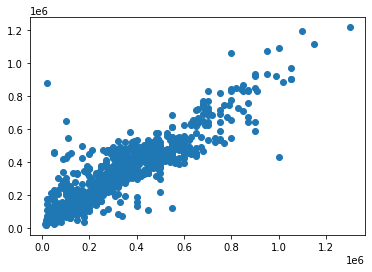

In [70]:
plt.scatter(y_target, y_target_predict)
plt.show()
# 이전보다는 좋은 성능을 보이고 있음

## GridSearchCV ... 최적의 값 찾기

In [72]:
from sklearn.model_selection import GridSearchCV

param ={
    'n_estimators' : [100, 500, 1000, 1500, 2000]
}

gs = GridSearchCV(rfr, param_grid=param)
gs.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(n_estimators=1000,
                                             random_state=42),
             param_grid={'n_estimators': [100, 500, 1000, 1500, 2000]})

In [73]:
gs.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__bootstrap', 'estimator__ccp_alpha', 'estimator__criterion', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__max_samples', 'estimator__min_impurity_decrease', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__oob_score', 'estimator__random_state', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [74]:
gs.best_params_

{'n_estimators': 500}

In [75]:
model = gs.best_estimator_
y_target_predict = model.predict(x_target)

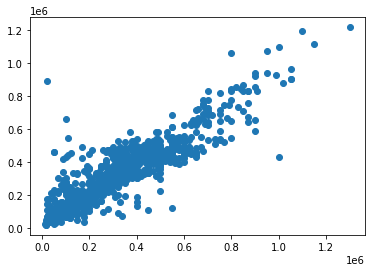

In [76]:
plt.scatter(y_target, y_target_predict)
plt.show()

### 파라미터 매개변수를 조금 더 주어야 성능이 개선됨

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV

param ={
    'n_estimators' : [100, 500, 1000, 1500, 2000],
    'max_features' : ['auto', 'sqrt'],
    'max_depth' : [int(x) for x in np.linspace(10, 100, num=11)],
    'bootstrap' : [True, False]
}

gs = GridSearchCV(rfr, param_grid=param)
gs.fit(x_train, y_train)

In [ ]:
gs.best_params_

In [ ]:
model = gs.best_estimator_
y_target_predict = model.predict(x_target)

In [ ]:
plt.scatter(y_target, y_target_predict)
plt.show()